In [2]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl


import torch

from time import time


from matplotlib          import rcParams, rc
rcParams.update({'figure.dpi': 200})
mpl.rcParams.update({'font.size': 10})
rc('font', family='serif')
rc('text', usetex=True)


import src.mace.CSE_0D.dataset  as ds
import src.mace.train                    as train
import src.mace.test                     as test
import src.mace.load                     as load
import src.mace.mace            as mace
from src.mace.loss                       import Loss
import src.mace.utils           as utils


def temp(Tstar, eps, r):
    Rstar = 2e13
    # r = 1e16
    T = Tstar * (r/Rstar)**(-eps)
    return T



dt_fracts = {4 : 0.296, 5: 0.269,8: 0.221,10: 0.175,12: 0.146,16: 0.117,20: 0.09,25: 0.078,32: 0.062,48: 0.043,64: 0.033,128: 0.017}


%reload_ext autoreload
%autoreload 2

## Functions

In [3]:
def test_model(model, testdata, meta):
    testpath = testdata.testpath[5]
    # print(testpath)

    # print('>> Loading test data...')
    CSEmod, input_data, info = ds.get_test_data(testpath,meta)

    n, n_hat, dt, mace_time = test.test_step(model, input_data)
    n_evol, mace_evol_time = test.test_evolution(model, input_data, start_idx=0)

    return input_data[0], n_hat, n_evol


def plot_test(n, n_hat):

    plt.plot(n_hat)
    plt.plot(n, 'k--', alpha = 0.2, lw = 0.5)

    plt.show()

    return

## Training

### Setup hyperparameters for mace model

In [4]:
## Set up PyTorch 
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} 

batch_size = 1
nb_test = 300

nb_samples = 100
z_dim = 8


traindata, testdata, data_loader, test_loader = ds.get_data(dt_fract=dt_fracts[z_dim],nb_samples=nb_samples,nb_test = nb_test, batch_size=batch_size, kwargs=kwargs)

Dataset:
------------------------------
  total # of samples: 100
#   training samples: 70
# validation samples: 30
               ratio: 0.3
     #  test samples: 300


### Local MACE training


The model has 284692 trainable parameters

Model:         
--------------
     # epochs: 2
learning rate: 1e-05
    loss type: abs_idn_grd

Local training scheme in use.

>>> Training model...
Epoch 1 complete! 	Average loss train:  15.86433 	Average loss test:  6.67036
              time [secs]:  20.45189
Epoch 2 complete! 	Average loss train:  15.10281 	Average loss test:  6.24526
              time [secs]:  27.00763

 	DONE!

 >>> Plotting...


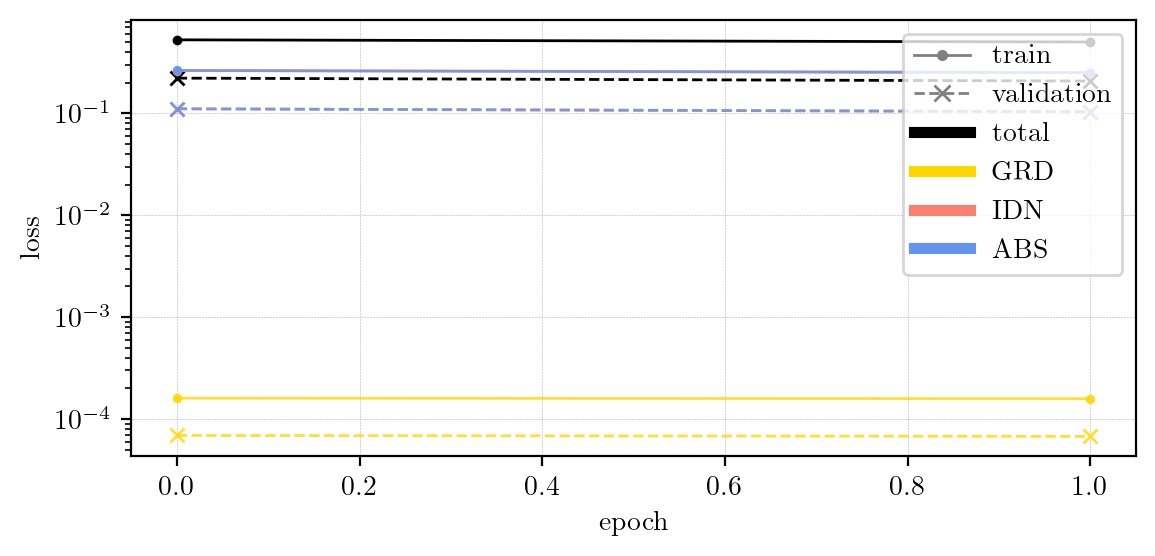

Total time [s]: 28.454345703125


In [6]:
## Local model

scheme = 'loc'
path = None
lr = 1.e-5
n_dim = 468
nb_hidden = 1
ae_type = 'simple'
nb_evol = 4


model = mace.Solver(n_dim=n_dim, p_dim=4,z_dim = z_dim, 
                    nb_hidden=nb_hidden, ae_type=ae_type, 
                    scheme=scheme, nb_evol=nb_evol,
                    path = path,
                    DEVICE = DEVICE,
                    lr=lr )

num_params = utils.count_parameters(model)
print(f'The model has {num_params} trainable parameters\n')


norm = {'abs' : 1,
        'grd' : 1,
        'idn' : 1,
        'elm' : 1}

fract = {'abs' : 1,
         'grd' : 1,
         'idn' : 1, 
         'elm' : 1}


epochs = 2
plot = True
losstype = 'abs_idn_grd'


meta = {  'nb_samples'  : nb_samples,
            'lr'        : lr,
            'epochs'    : epochs,
            'z_dim'     : z_dim,
            'losstype'  : losstype,
            'nb_evol'   : nb_evol,
            'nb_hidden' : nb_hidden,
            'ae_type'   : ae_type,
            'dt_fract'  : dt_fracts[z_dim],
            'nb_test'   : nb_test,
            'done'      : 'false',
}


## Make loss objects
trainloss = Loss(norm, fract, losstype)
testloss  = Loss(norm, fract, losstype)


tic = time()
train.train(    model, 
                data_loader, test_loader, 
                end_epochs = epochs, 
                trainloss=trainloss, testloss=testloss, 
                start_time = time(), 
                plot=plot)
toc = time()

print('Total time [s]:',toc-tic)




In [7]:
trainloss.get_all_losses()

{'tot': array([0.5288111 , 0.50342693]),
 'abs': array([0.26459455, 0.25189382]),
 'grd': array([0.00016002, 0.00015805]),
 'idn': array([0.26405653, 0.25137506]),
 'elm': array([0., 0.])}

>>> Testing step...
Solving time [s]: 0.004687070846557617

>>> Testing evolution...


100%|██████████| 133/133 [00:00<00:00, 267.37it/s]


Solving time [s]: 0.49489855766296387
Total   time [s]: 0.5023384094238281


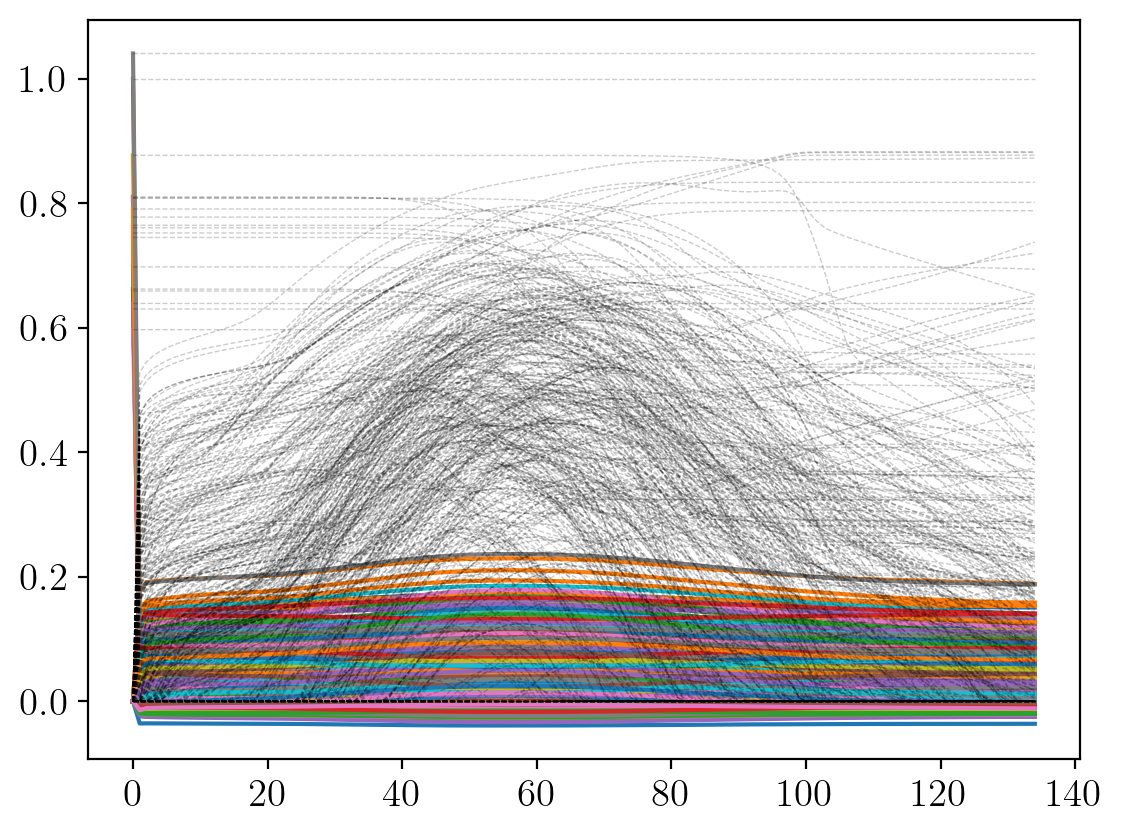

In [8]:
n, n_hat, n_evol = test_model(model, testdata, meta)

plot_test(n, n_hat)

### Integrated MACE training


The model has 284692 trainable parameters

Model:         
--------------
     # epochs: 2
learning rate: 1e-05
    loss type: abs_idn_grd

Integrated training scheme in use.

>>> Training model...
Epoch 1 complete! 	Average loss train:  15.95208 	Average loss test:  6.71954
              time [secs]:  13.38243
Epoch 2 complete! 	Average loss train:  15.27053 	Average loss test:  6.36105
              time [secs]:  28.56659

 	DONE!

 >>> Plotting...


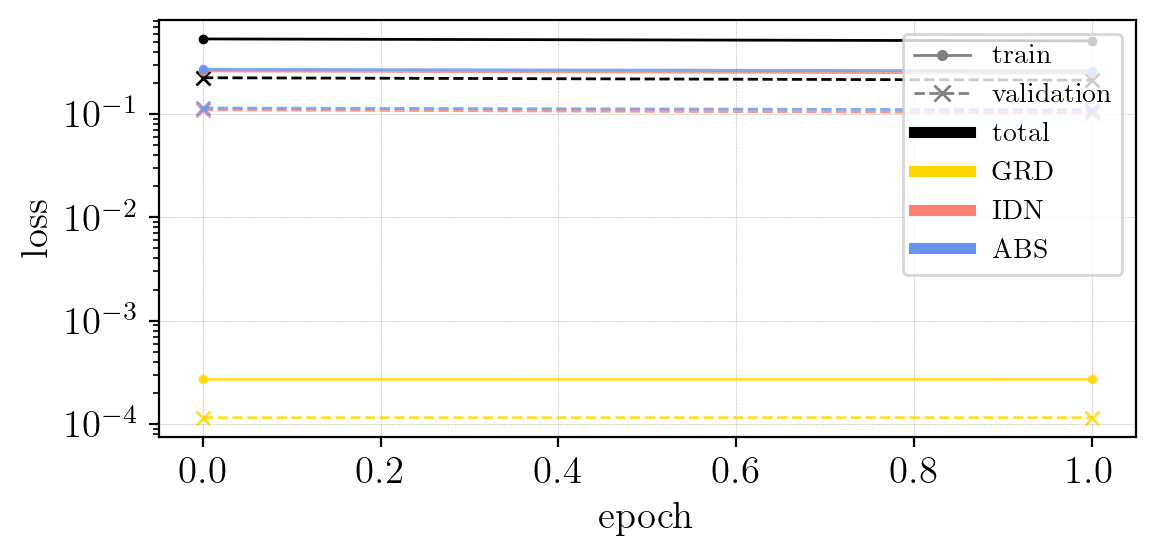

Total time [s]: 29.71979856491089


In [9]:
## Integrated model

scheme = 'int'
nb_evol = 8
path = None
lr = 1.e-5
n_dim = 468
nb_hidden = 1
ae_type = 'simple'


model_integr = mace.Solver(p_dim=4,z_dim = z_dim, n_dim=n_dim, 
                           scheme= scheme, nb_evol=nb_evol,
                           nb_hidden=nb_hidden, ae_type=ae_type, 
                           DEVICE = DEVICE,
                           path = path, 
                           lr=lr)

num_params = utils.count_parameters(model)
print(f'The model has {num_params} trainable parameters\n')


norm = {'abs' : 1,
        'grd' : 1,
        'idn' : 1}

fract = {'abs' : 1,
         'grd' : 1,
         'idn' : 1}


lr = 1.e-5
epochs = 2
plot = True
losstype = 'abs_idn_grd'

meta_int = {'nb_samples': nb_samples,
            'lr'        : lr,
            'epochs'    : epochs,
            'z_dim'     : z_dim,
            'losstype'  : losstype,
            'nb_evol'   : nb_evol,
            'nb_hidden' : nb_hidden,
            'ae_type'   : ae_type,
            'dt_fract'  : dt_fracts[z_dim],
            'nb_test'   : nb_test,
            'done'      : 'false',
}


## Make loss objects
trainloss_integr = Loss(norm, fract, losstype)
testloss_integr  = Loss(norm, fract, losstype)


tic = time()
train.train(model_integr, 
                data_loader, test_loader, 
                end_epochs = epochs, 
                trainloss=trainloss_integr, testloss=testloss_integr, 
                start_time = time(), plot=plot)
toc = time()

print('Total time [s]:',toc-tic)




>>> Testing step...
Solving time [s]: 0.005531787872314453

>>> Testing evolution...


100%|██████████| 133/133 [00:00<00:00, 306.48it/s]


Solving time [s]: 0.4332869052886963
Total   time [s]: 0.4398329257965088


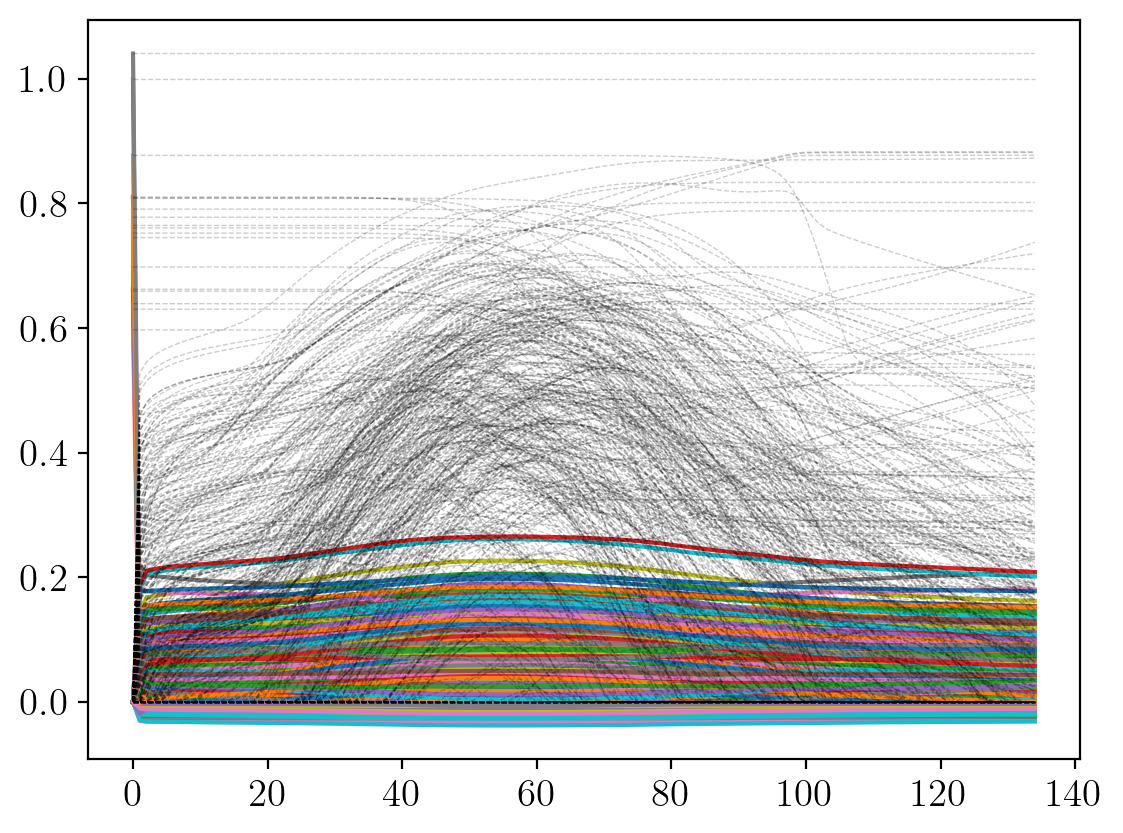

In [12]:
n, n_hat, n_evol = test_model(model_integr, testdata, meta_int)

plot_test(n, n_hat)

## Loading MACE models

In [16]:
outloc  = '/STER/silkem/MACE/models/CSE_0D/'
dirname = '20240207_134859_66656_4'

trained = load.Trained_MACE(outloc=outloc, dirname=dirname)
model = trained.model

The model has 284692 trainable parameters


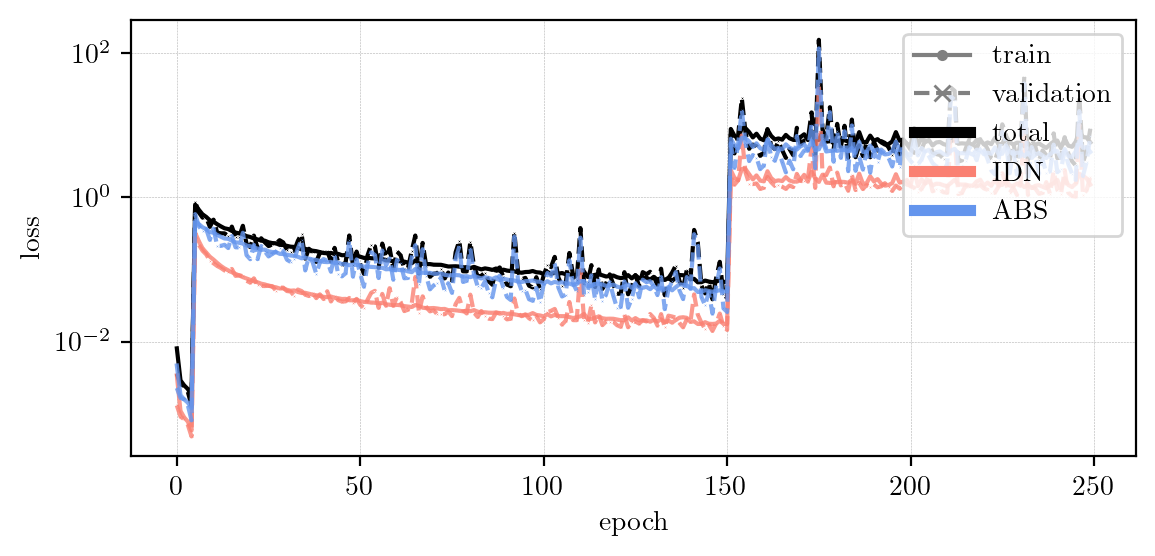

In [17]:
trained.plot_loss(save=False)

>>> Testing step...
Solving time [s]: 0.00878596305847168

>>> Testing evolution...


100%|██████████| 133/133 [00:00<00:00, 276.13it/s]


Solving time [s]: 0.48000669479370117
Total   time [s]: 0.48738813400268555

>>> Denormalising... 

Errors (following Eq. 23 of Maes et al., 2024):
      Step error: 4.719
 Evolution error: 6.968

>>> Plotting...


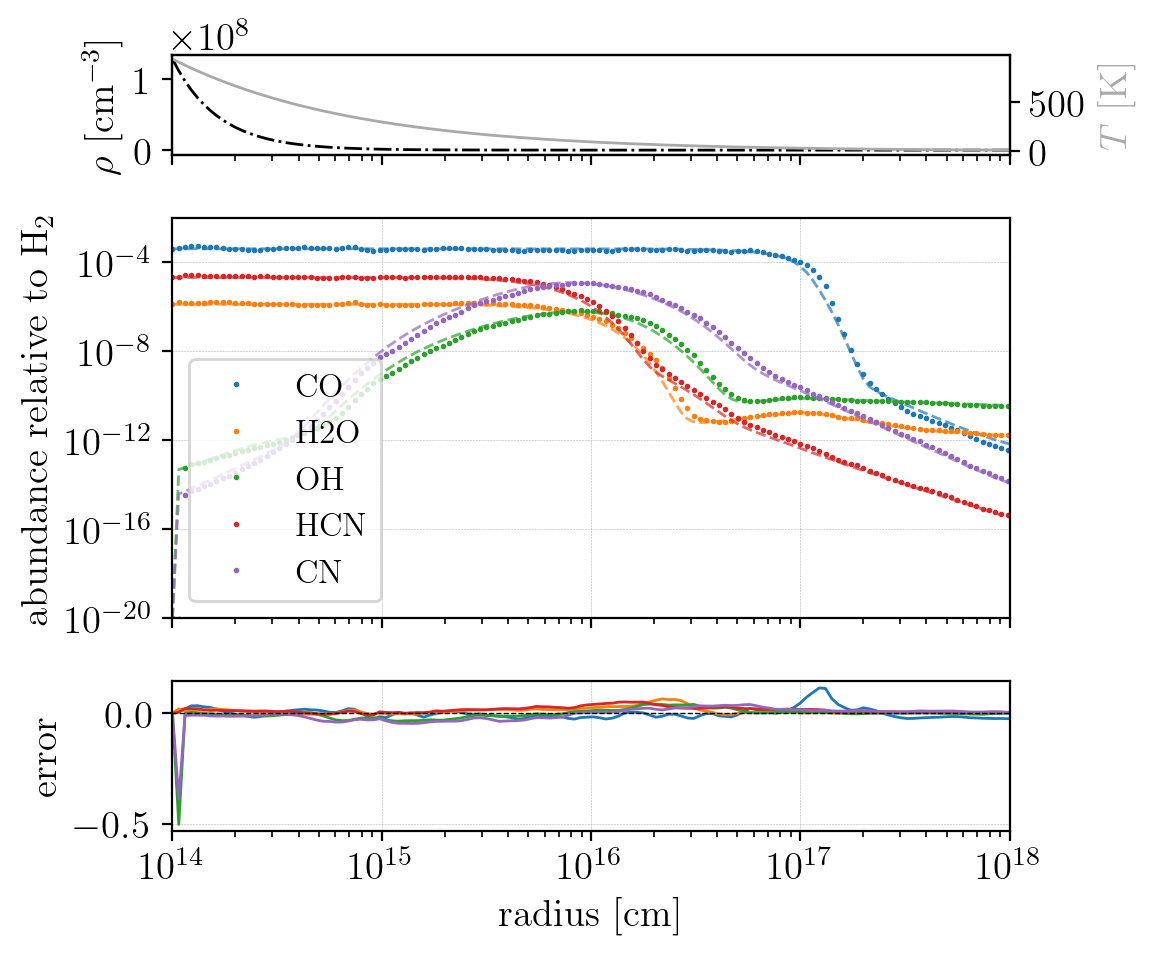

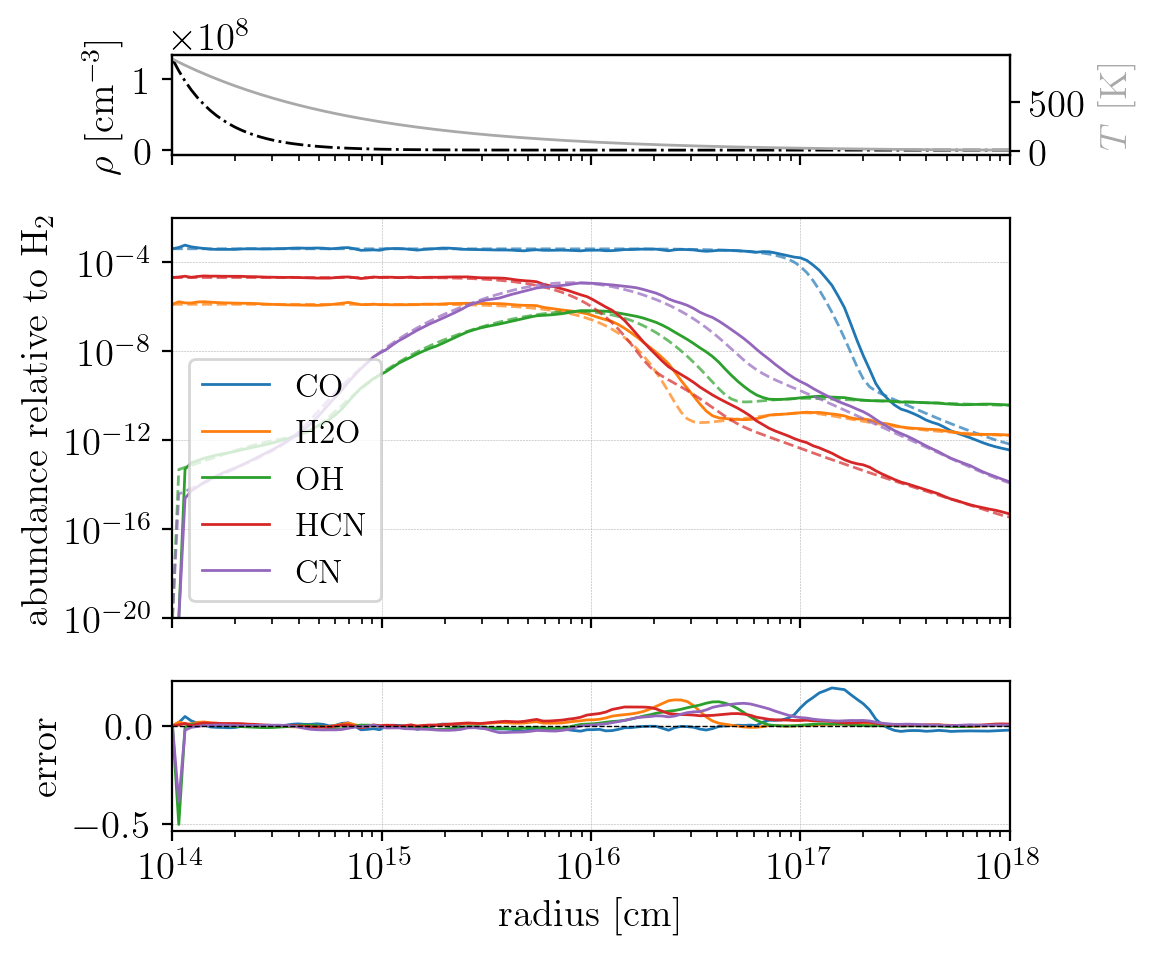

In [20]:
testpath = '/lhome/silkem/CHEM/Output_nov2022/20211015_gridC_Mdot1e-6_v17-5_T_eps/models/model_2022-12-24h17-06-51/csfrac_smooth.out'
specs = ['CO', 'H2O', 'OH', 'HCN', 'CN']
# specs = []
# print(len(specs))

macetime = trained.test(testpath, specs, plotting=True)

## Random testing


In [6]:
utils.get_specs()

({'H': 0,
  'H+': 1,
  'H-': 2,
  'H2+': 3,
  'H3+': 4,
  'He': 5,
  'He+': 6,
  'HeH+': 7,
  'C-': 8,
  'C+': 9,
  'C': 10,
  'CH-': 11,
  'CH+': 12,
  'CH': 13,
  'CH2+': 14,
  'N+': 15,
  'CH2': 16,
  'N': 17,
  'CH3': 18,
  'NH': 19,
  'NH+': 20,
  'CH3+': 21,
  'O+': 22,
  'NH2+': 23,
  'CH4+': 24,
  'O-': 25,
  'NH2': 26,
  'O': 27,
  'CH4': 28,
  'OH-': 29,
  'OH': 30,
  'OH+': 31,
  'CH5+': 32,
  'NH3+': 33,
  'NH3': 34,
  'NH4+': 35,
  'H2O': 36,
  'H2O+': 37,
  'F': 38,
  'H3O+': 39,
  'F+': 40,
  'HF': 41,
  'HF+': 42,
  'H2F+': 43,
  'Na': 44,
  'Na+': 45,
  'C2-': 46,
  'C2+': 47,
  'Mg': 48,
  'Mg+': 49,
  'C2': 50,
  'C2H-': 51,
  'C2H+': 52,
  'C2H': 53,
  'CN': 54,
  'C2H2': 55,
  'C2H2+': 56,
  'CN-': 57,
  'CN+': 58,
  'HCN': 59,
  'C2H3': 60,
  'C2H3+': 61,
  'HCN+': 62,
  'HNC': 63,
  'N2': 64,
  'C2H4+': 65,
  'Si+': 66,
  'H2CN': 67,
  'H2NC+': 68,
  'N2+': 69,
  'Si': 70,
  'CO': 71,
  'CO+': 72,
  'C2H4': 73,
  'HCNH+': 74,
  'C2H5+': 75,
  'HCO': 76,
  'SiH+':

In [13]:
import src.mace.autoencoder as ae

input_ae_dim = 468+4
n_dim = 468
z_dim = 8
nb_hidden = 1
ae_type = 'simple'

encoder = ae.Encoder(input_dim=input_ae_dim, latent_dim=z_dim, nb_hidden=nb_hidden, ae_type=ae_type)
decoder = ae.Decoder(latent_dim=z_dim      , output_dim=n_dim, nb_hidden=nb_hidden, ae_type=ae_type)

coder = ae.Autoencoder(encoder, decoder)


ae.overview(coder)

___________________________________

Encoder
       # | nodes | parameters
-----------------------------------
   input |   472 |     124872
  hidden |   264 |      16960
  hidden |    64 |        520
  output |     8 |          /
-----------------------------------
         |       |     142352

Decoder
       # | nodes | parameters
-----------------------------------
   input |     8 |        576
  hidden |    64 |      17160
  hidden |   264 |     124020
  output |   468 |          /
-----------------------------------
         |       |     141756
___________________________________

